<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Point Spread Function (PSF) Analysis for Cosmology </b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  2024-02-28 <br>
LSST Science Pipelines version: Weekly 2024_04  <br>
Container Size: medium <br>
Targeted learning level: advanced <br>

**Description:** Demonstration of the use of measured PSF properties in weak lensing analysis. **Adapted to use the dp02_dc2_catalogs_frdf catalogs produced at CC-IN2P3.**

**Skills:** Use of the catalog data products for PSF analysis. 

**LSST Data Products:** DP0.2 `Object` and `Source` catalogs.

**Packages:** lsst.analysis.tools.atools

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Jeff Carlin, Douglas Tucker, Ryan Lau, and the Rubin Community Science Team for DP0.2. The section on PSF size and its correlation function using the `treecorr` software is based on a Jupyter notebook authored by Claire-Alice Hebert. The section on PSF size histograms and their dependency on the central filter wavelength is derived from a Jupyter Notebook by Tianqing Zhang. The section on `rho` statistics using `lsst.analysis.tools` draws from a Jupyter Notebook by Arun Kannawadi.
This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

In the context of astronomical surveys, such as the Vera C. Rubin Observatory's Legacy Survey of Space and Time (LSST), 
a significant objective is to extract cosmological information by scrutinizing subtle deviations in the 
shapes and orientations of galaxies. 
These deviations are caused by gravitational lensing from large-scale structures in the foreground. 
However, the observed shapes of galaxies are not solely influenced by the gravitational lensing effects 
of the universe's large-scale structure (referred to as "cosmic shear"), 
but also by a combined blurring effect known as the point spread function (PSF). 
The PSF arises from various factors such as atmospheric conditions (for ground-based instruments), 
telescope optics, and the image sensor.
PSF analysis is thus an integral part of cosmological studies (and is important in other astronomical fields as well).

Whereas the introductory DP0.2 PSF tutorial notebook (DP02_12a_PSF_Data_Products) demonstrated how to access
PSF information for `calexp` and `deepCoadd` images, this tutorial focuses on the measured PSF information
that is available in the `Source` and `Object` catalogs for sources detected in the `calexp` and `deepCoadd`
images, respectively.

**Section 2** introduces and explores the PSF measurements that are available in the `Object` and `Source` catalogs.
Two TAP queries are executed: one to retrieve a set of `Objects` detected in the `deepCoadd` images,
and one to retrieve a set of `Sources` detected in a `calexp` (single visit) image at the same location.

**Section 3** calculates and displays the size of the PSF in a particular photometric band (`i`) as a function of sky location. 
It also computes the size-size two-point correlation function (autocorrelation) using the `treecorr` software. 
This software is widely used in state-of-the-art weak lensing analyses to derive cosmological parameters. 
These calculations are performed using both `calexp` and `deepCoadd` images.

**Section 4** illustrates one chromatic dependence of the PSF: the wavelength dependence of the PSF size.

**Section 5** calculates the rho statistics, a series of two-point correlation functions used to diagnose 
the quality of a PSF model for weak lensing analyses. This calculation is done using the `lsst.analysis.tools` framework.

**Additional resources.** 

It is not required to review and understand the following resources before working through this tutorial.

For an overall review on PSF modelling and a look towards the future, see
"Point spread function modelling for astronomical telescopes: a review focused on weak gravitational lensing studies" by
[Liaudat et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230607996L/abstract).
For papers on the impact of chromatic effects on the PSF on weak lensing cosmology see 
"Atmospheric Dispersion Effects in Weak Lensing Measurements" by 
[Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract),
or "Impact of Atmospheric Chromatic Effects on Weak Lensing Measurements" by
[Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract).
For a paper on the impact of differential chromatic refraction (DCR) on supernova cosmlogy, see
"The Dark Energy Survey Supernova Program: Corrections on Photometry Due to Wavelength-dependent Atmospheric Effects" by
[Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract).

For more details on PSF modeling and null tests for galaxy surveys, including `rho` statistics, see
"Dark Energy Survey year 3 results: point spread function modelling" by 
[Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract),
or
"The three-year shear catalog of the Subaru Hyper Suprime-Cam SSP Survey" by
[Li et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract).
And finally, for an approach to a mathematical framework that aids in producing well-defined coadded PSFs for static-sky sources,
see "PSFs of coadded images" by
[Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract).

### 1.1. Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/),
and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing and analysis.
The [treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) package by
[Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) 
is a widely used tool for fast correlations measurements based on a ball tree method 
(similar to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree)). 
In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.
The `lsst.analysis.tools` package is in-developement by Rubin staff for the 
creation of consistent and repeatable plots and metrics.
Intermediate and advanced users are welcome to use it too; more information is available in the 
[analysis tools documentation](https://pipelines.lsst.io/modules/lsst.analysis.tools/index.html).

> **Warning:** The ``FutureWarning`` that might appear below about ``lsst.pipe.tasks.configurableActions`` being deprecated
> is ok to ignore for now, it does not affect any functionality in this notebook. It will be fixed in the future.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import treecorr

from lsst.rsp import get_tap_service
from lsst.analysis.tools.atools import RhoStatistics

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/analysis_tools/g67abf2d982+513a741855/python/lsst/analysis/tools/tasks/catalogMatch.py:31: FutureWarning: lsst.pipe.tasks.configurableActions is deprecated; it has been moved to lsst.pex.config.configurableActions. Accessing though lsst.pipe.tasks will be removed from Science Pipelines after release 26.0.0
  from lsst.pipe.tasks.configurableActions import ConfigurableActionStructField


### 1.2. Define functions and parameters

Instantiate the TAP service for DP0.2 catalog access.

In [2]:
service = get_tap_service("tap")

Set a standard color style.

In [3]:
plt.style.use('tableau-colorblind10')

**Function**: `powerLaw`

Defines a power-law function.

In [4]:
def powerLaw(lam, a, b):
    """Function to return a power-law.

    Parameters
    ----------
    lam : `array`
       array of values
    a : `float`
       constant factor
    b : `float`
       power

    Returns
    -------
    result : `float`
        a*lam**(-b)
    """

    result = a*lam**(-b)
    return result

## 2. The measured PSF properties in the catalogs

Recall that the `Objects` and `Sources` catalogs contains measurements for astrophysical objects 
detected in the `deepCoadd` and `calexp` (single-visit) images, respectively.

These measurements include a variety of parameters that characterize the PSF as measured for
that `Object` or `Source`.
While these parameters are calculated for all detections, they
are only relevant for point-sources (stars) and not extended sources (galaxies).

### 2.1. PSF properties for `Objects`

To explore what PSF-related measurements exist, one option is to page search for the term "psf" in the 
[DP0.2 Catalogs Schema Browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html) for the `Object` table.

**Option:** To retrieve the column names and descriptions for the `Object` table and search for the term "psf",
uncomment the lines in the following cell and execute the cell.
The result is quite a long list, so this cell is commented-out by default.

In [5]:
# results = service.search("SELECT column_name, description "
#                          "from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs_frdf.Object'"
#                          ).to_table().to_pandas()
# for cname, descr in zip(results['column_name'], results['description']):
#     if (cname.find('psf') > -1) | (cname.find('PSF') > -1):
#         print(cname + ' --- ' + descr)
# del results

The `Object` catalog contains measurements for sources detected in the `deepCoadd` images for *all* six filters, *ugrizy*.
Thus, for all the PSF-related measurements in the `Object` catalog, there is one per band.

Some of the most useful PSF-related parameters in the `Object` catalog include the following.

`{band}_psfFlux` and `{band}_psfFluxErr`:
The flux (and its error) derived from linear least-squares forced-fit of PSF model.

`{band}_psfFlux_flag`: A general failure flag for the linear least-squares forced-fit of PSF model (`True` or `1` if failed).

`{band}_ixxPSF`, `{band}_ixyPSF`, and `{band}_iyyPSF`: Second-moments of the shape of the fit PSF model ($I_{xx}$, $I_{yy}$, and $I_{xy}$).

`{band}_calib_psf_used`: A flag that is `True` (or `1`) if the `Object` is a star that was used to establish the PSF model
for the image (i.e., bright isolated stars with well-measured PSF properties).

`{band}_pixelFlags_inexact_psfCenter`: A flag that is `True` (or `1`) if the `Object` is close to image pixels which do not
have an exact PSF, typically because they are near an image edge. 
Objects near these edges can have a discontinuous PSF.

#### 2.1.1. Retrieve a sample of `Objects`

Use the same central coordinates as were used to retrieve the images in the introductory PSF tutorial notebook
(DP02_12a_PSF_Data_Products.ipynb).

Use the same default filter, *i*.

In [6]:
use_center_coords = "53.0, -34.1"
band = 'i'

The following query retrieves the PSF-related columns mentioned above, plus a few more columns
which will be used later in this notebook, when calculating rho statistics with the analysis tools pacakge.

The `WHERE` statements for this query require object to:
 - be within a 2 degree radius around the center coordinates;
 - have a `detect_isPrimary` flag that is `True` (`1`), which is always recommended as a way to avoid duplicates and unblended objects;
 - have a flux $> 360$ nJy (i.e., be bright);
 - have an extendedness parameter $= 0$ (stars only, no extended objects);
 - have a `{band}_calib_psf_used` flag that is `True` (`1`), such that only stars with well-measured PSF properties are returned;
 - and have a `{band}_pixelFlags_inexact_psfCenter` flag that is `False` (`0`) to avoid stars near the image edge.
 
The choice to requre that `i_pixelFlags_inexact_psfCenter = 0` is influenced by the fact that the `EDGE` 
flag in a `calexp` corresponds to the `SENSOR_EDGE` flag in the `coadd`. 
Objects near these edges have a discontinuous PSF. 
Additionally, the `inexact_psfCenter` results from an `OR` operation that includes `SENSOR_EDGE`. 
The other properties retrieved through the query will play a role in calculating the `rho` statistics, 
which will be the subject of Section 5 in this notebook.

In [7]:
objects = service.search("SELECT coord_ra, coord_dec, "
                         f"{band}_psfFlux, "
                         f"{band}_psfFluxErr, "
                         f"{band}_psfFlux_flag, "
                         f"{band}_pixelFlags_saturatedCenter, "
                         f"{band}_extendedness, "
                         f"{band}_extendedness_flag, "
                         f"{band}_ixy, {band}_ixyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, "
                         "xy_flag, sky_object, "
                         "detect_isPatchInner, "
                         "detect_isDeblendedSource "
                         "FROM dp02_dc2_catalogs_frdf.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         f"AND {band}_calibFlux > 360 "
                         f"AND {band}_extendedness = 0.0 "
                         f"AND {band}_calib_psf_used = 1 "
                         f"AND {band}_pixelFlags_inexact_psfCenter = 0 ").to_table().to_pandas()

**Option:** View the table. This query returns 8426 rows.

In [8]:
# objects

Calculate the trace radius (PSF size, $r_t$) for the *u*, *g*, *r*, and *i*-band 
from the second moments of the PSF shape as $r_t = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$.

In [9]:
for band in ['u', 'g', 'r', 'i']:
    objects['size_'+band+'_PSF'] = np.sqrt((objects[band + '_ixxPSF']
                                            + objects[band + '_iyyPSF']) / 2)

The PSF sizes in different filters will be used below to explore the wavelength dependence of seeing.

### 2.2. PSF properties for `Sources`

**Option:** To retrieve the column names and descriptions for the `Source` table and search for the term "psf",
uncomment the lines in the following cell and execute the cell.

In [10]:
# results = service.search("SELECT column_name, description "
#                          "from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs_frdf.Source'"
#                          ).to_table().to_pandas()
# for cname, descr in zip(results['column_name'], results['description']):
#     if (cname.find('psf') > -1) | (cname.find('PSF') > -1):
#         print(cname + ' --- ' + descr)
# del results

The `Source` catalog contains mostly the same PSF-related columns as the `Object` table.

However, since `Sources` are measured only in one `calexp` (single visit) image, columns for each of the
six filters are not needed.
The `Sources` catalog has a column named `band` that stores the filter of the `calexp`, which is the filter
in which all the PSF-related measurements for the `Source` have been made.

#### 2.2.1. Retrieve a sample of `Sources`

The following query retrieves PSF-related columns for `Sources` detected in visit number 192350,
which is the same visit used in the introductory PSF notebook and which is already known to be in the *i*-band
and to overlap the sky coordinates used for the `Object` query.

Similar `WHERE` constraints are used as above, but since the `Source` table does not have an 
equivalent to `{band}_pixelFlags_inexact_psfCenter` in the `Object` table,
the constraint that the `pixelFlags_suspectCenter` flag is `False` (`0`) is used to exclude sources near

The `Source` table is much larger than the `Object` table and so this query can take a few minutes.

In [11]:
sources = service.search("SELECT coord_ra, coord_dec, "
                         "ixx, iyy, ixy, ixxPSF, iyyPSF, ixyPSF "
                         "FROM dp02_dc2_catalogs_frdf.Source "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         "AND calibFlux > 360 "
                         "AND extendedness = 0.0 "
                         "AND calib_psf_used = 1 "
                         "AND pixelFlags_suspectCenter = 0 "
                         "AND visit = 192350").to_table().to_pandas()

**Option:** View the table. This query returns 8049 rows.

In [12]:
# sources

Calculate the trace radius.

In [13]:
sources['size_PSF'] = np.sqrt((sources['ixxPSF'] + sources['iyyPSF']) / 2)

## 3. Visualize the PSF size and its correlation function with `treecorr`

The two-point correlation functions hold significant importance in weak lensing cosmological analysis, 
as they allow for the inference of crucial cosmological parameters. 

Notably, `treecorr` serves as the standard tool employed by various collaborations, including the 
Dark Energy Survey and the Hyper-Suprime Camera Survey. 
It's also a prominent choice utilized by the LSST Science Pipelines code.

In a broader sense, the two-point correlation function serves as a statistical metric that aids in comprehending the distribution and potential correlations of random variables within space or time.
In cosmology, this function was introduced as a means to quantify the excess probability of locating two galaxies at a specific distance apart, as opposed to an expected uniform distribution ([Pebbles 1980](https://ui.adsabs.harvard.edu/abs/1980lssu.book.....P/abstract)). 
In modern galaxy surveys such as the Dark Energy Survey (DES), this tool is applied for cross-correlating key quantities like galaxy number counts and weak lensing shear in a "3x2" point analysis. 
This analysis methodology is employed to deduce constraints on cosmological parameters, and it's an approach that will also be adopted by the Legacy Survey of Space and Time (LSST) (refer to [DES Collaboration 2022](https://ui.adsabs.harvard.edu/abs/2022PhRvD.105b3520A/abstract)).

Below, the `treecorr` software ([Jarvis et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)) 
is used to compute the two-point correlation function of the PSF model size as a function of angular separation.
For more information about `treecorr`, check its [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html).

### 3.1. For `Objects`

Temporarily store the `object` right ascention and declination coordinates in the `obj_ra `and `obj_dec` variables.

In [14]:
obj_ra = objects['coord_ra']
obj_dec = objects['coord_dec']

Define `treecorr`'s catalog and adjust a few of its parameters. 

In [15]:
cat = treecorr.Catalog(ra=obj_ra, dec=obj_dec,
                       k=objects[f'size_{band}_PSF']
                       - np.mean(objects[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')

kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}

Calculate the two-point correlation function of the size. In this case, this is an auto-correlation (size-size two point correlation).

In [16]:
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)

Retrieve the correlation function, denoted by `xi`, and the angular separation arrays:

In [17]:
xi = kk.xi
bins = kk.rnom

Plot the PSF size as a function of sky coordinates, and the correlation function.

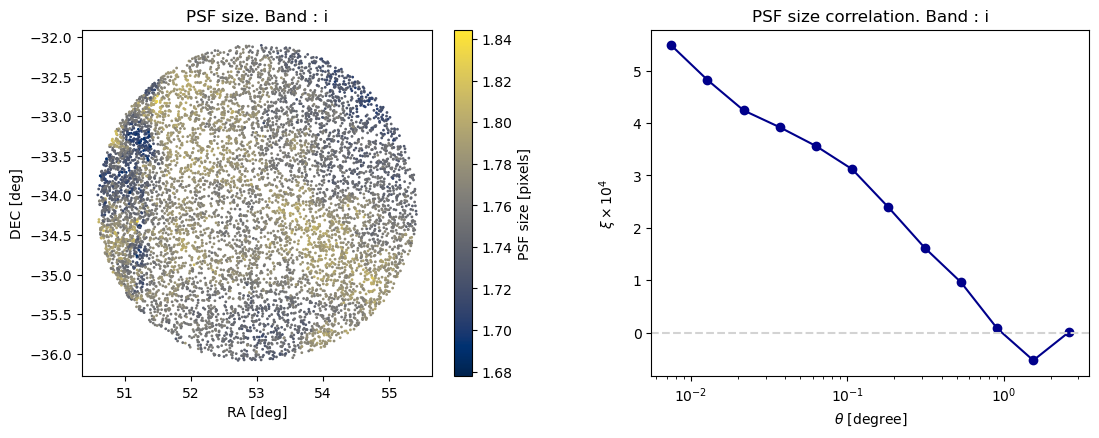

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(obj_ra, obj_dec, c=objects[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='PSF size [pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins), xi*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=10)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

> **Figure 1:** *The figure above consists of two panels. The left panel illustrates the PSF size within the investigated circle and band, as a function of declination (ranging from approximately negative 36 to negative 32 degrees) and right ascension (ranging from around 51 to 55 degrees). The PSF size or trace radius is depicted using a color scale, with values ranging from about 1.68 to 1.78 pixels. The right panel of the figure showcases the two-point autocorrelation function of the PSF size, plotted against angular separations in degrees. The correlation function values are expressed as multiples of 1e4, spanning from negative 1 to 4. Angular separations are marked on the abscissa axis, ranging from 0.01 to 2 degrees, and are represented on a logarithmic scale.*

### 3.2. For `Sources`

Temporarily store the `sources` right ascention and declination coordinates in the `src_ra `and `src_dec` variables.

In [19]:
src_ra = sources['coord_ra']
src_dec = sources['coord_dec']

Define `treecorr`'s catalog and adjust a few of its parameters, calculate the two-point correlation function of the size, and retrieve it, along with the angular seprations. 

In [20]:
cat = treecorr.Catalog(ra=src_ra, dec=src_dec,
                       k=sources['size_PSF']
                       - np.mean(sources['size_PSF']),
                       ra_units='deg', dec_units='deg')
kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)
xi_source = kk.xi
bins_source = kk.rnom

Plot the PSF size as a function of sky coordinates, and the correlation function.

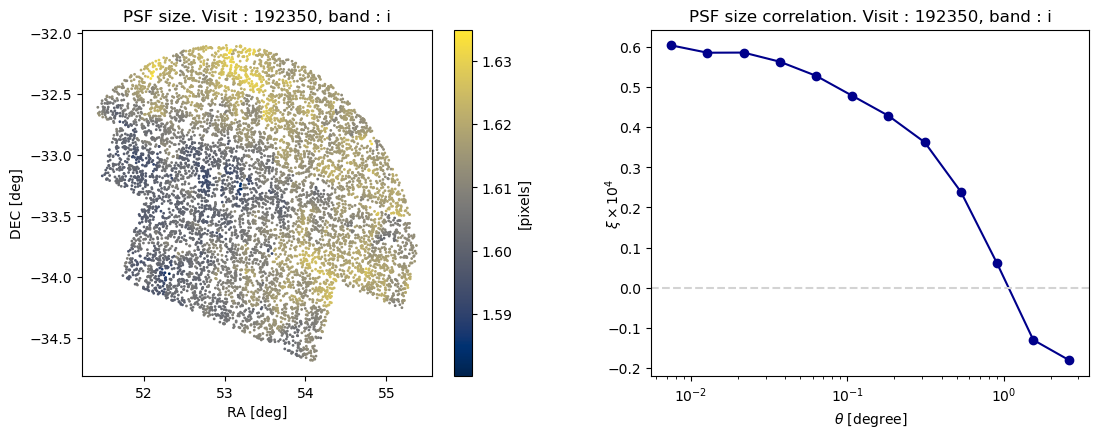

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title('PSF size. Visit : 192350, band : i')
scatter_plot = ax1.scatter(src_ra, src_dec,
                           c=sources['size_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='[pixels]')

ax2.set_title('PSF size correlation. Visit : 192350, band : i')
ax2.plot(np.degrees(bins_source), xi_source*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

> **Figure 2:** *The figure above consists of two panels. The left panel illustrates the PSF size for sources detected in a single visit as a function of sky coordinate, and which are within two degrees of the specified central coordinates. These coordinates are clearly near the edge of the field of view, as the outline of the CCD array edge is seen. The PSF size or trace radius is depicted using a color scale, with values ranging from about 1.59 to 1.63 pixels. The right panel of the figure showcases the two-point autocorrelation function of the PSF size, plotted against angular separations in degrees. The correlation function values are expressed as multiples of 1e4, spanning from negative 0.2 to 0.6. Angular separations are marked on the abscissa axis, ranging from 0.01 to 2 degrees, and are represented on a logarithmic scale.*


### 3.3. Discussion 

By comparing Figure 1 and Figure 2, it is clear that the PSF size exhibits variations in both the `deepCoadds` (`Objects`) and in individual `calexps` (`Sources`). For the latter, the gradient observed is dominated by Kolmogorov turbulence, demonstrating the turbulent seeing variation across the focal plane. These variations are averaged down in the case of the `deepCoadds`, and therefore the correlation function decreases faster with distance. Both are in the `i` band in this case, and as a consequence, there are no chromatic variations in size coming from effects such as Differential Chromatic Refraction (DCR) or the seeing dependence with wavelength, which will be explored in the next section.

## 4. The wavelength dependence of seeing  

To correct for the effects of the Point Spread Function (PSF) and to deduce the weak lensing signal (referred to as "shear") from galaxy shapes, the PSF is typically modeled using stars, often bright ones. Subsequently, the PSF of galaxy images is deconvolved by utilizing the estimated PSF convolution kernel. Implicit in this methodology is the assumption that the convolution kernel for galaxies remains the same as that for stars. However, this assumption becomes invalid if the PSF varies with wavelength due to the distinctive Spectral Energy Distributions (SEDs) of stars and galaxies, resulting in disparate PSFs.

In this section, use the point source sample derived from the `Object` catalog, which was obtained in the preceding sections. Aftwerward, compute one of the wavelength-dependent components contributing to the PSF owing to atmospheric effects: the wavelength dependence on seeing. As per the standard theory of atmospheric turbulence, the linear dimension `θ` of the atmospheric convolution kernel (i.e., seeing) is inversely proportional to the wavelength, expressed as $\theta \propto \lambda^{-\frac{1}{5}}$.

Additional wavelength-dependent contributions to the PSF encompass Differential Chromatic Refraction (DCR), telescope diffraction, variations in the absorption length of camera CCDs, and optical chromatic aberrations. In general, each of these factors exhibits distinct functional wavelength dependencies and may exert dominance in different spectral bands. Nevertheless, the wavelength-dependent seeing that we explore in this section tends to be the primary contributor to the PSF. These chromatic PSF effects introduce biases in observables such as photometry, astrometry, measurements of galaxy shape and size, and higher-order moments of the PSF. Addressing these effects is imperative for precise cosmological analysis employing weak gravitational lensing. For more detailed information, refer to the works of [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract), [Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract), [Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract), [Tianqing et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.520.2328Z/abstract), and [Meyers and Burchat 2015b](https://ui.adsabs.harvard.edu/abs/2015JInst..10C6004M/abstract).

To replicate this wavelength relationship using the date retreived above, compute first the central wavelengths of the broadband filters employed by LSST, alongside determining the mean size and its standard deviation for each respective band. The boundaries of the filters are available in Table 2.1 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).

In [22]:
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(objects['size_u_PSF']),
             np.mean(objects['size_g_PSF']),
             np.mean(objects['size_r_PSF']),
             np.mean(objects['size_i_PSF'])]

std_size = [np.std(objects['size_u_PSF']),
            np.std(objects['size_g_PSF']),
            np.std(objects['size_r_PSF']),
            np.std(objects['size_i_PSF'])]

Fit now a power-law to the mean PSF size in relation to wavelength by employing [`scipy.optimize.curvefit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). 

This function takes the functional form to be fitted as its first argument, followed by two arrays containing the data. The output is a tuple consisting of the optimized parameters that minimize the squared residuals of the function with respect to the measured data, labeled as `popt`. Additionally, it provides the estimated 2D covariance matrix of the fitted parameters, denoted as `pcov`, wherein the diagonal elements offer an estimation of their respective one-standard-deviation errors (for more comprehensive information, refer to [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

In [23]:
popt, pcov = curve_fit(powerLaw, wavelength, mean_size)
perr = np.sqrt(np.diag(pcov))

Use the fitted parameters to define fitted values, and print the parameters of the fit.

In [24]:
lamb_grid = np.arange(300, 800, 1)
fit_size = powerLaw(lamb_grid, *popt)
amplitude, exponent = popt
amplitude_error, exponent_error = perr
print(f"Amplitude: {amplitude:.3} +/- {amplitude_error:.3}")
print(f"Exponent: {exponent:.3} +/- {exponent_error:.3}")

Amplitude: 5.41 +/- 0.342
Exponent: 0.169 +/- 0.0101


The fitted exponent, `-0.196 +/- 0.0235` is within one-sigma of the expected value of `-1/5=-0.2`. 

Plot the mean PSF size per band as a function of wavelength.

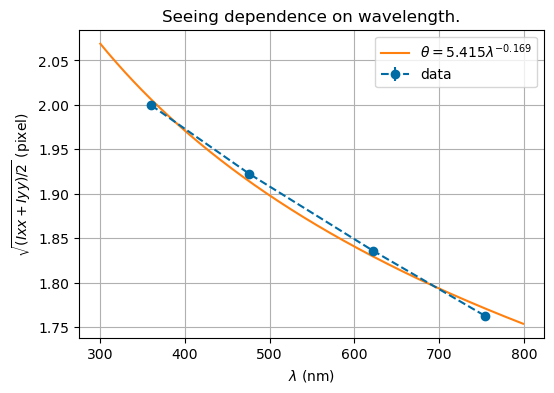

In [25]:
plt.figure(figsize=(6, 4))
plt.errorbar(wavelength, mean_size, std_size/np.sqrt(len(objects)),
             fmt='o--', label='data')
plt.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
plt.title("Seeing dependence on wavelength.")
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

> **Figure 3**: *The plot above depicts the mean PSF size (expressed as the trace radius in pixels) in relation to the central wavelength for the previously specified LSST filters. Additionally, a power-law fit is presented on the same plot, with the associated amplitude and fitting parameters indicated within the legend.*

Superimpose the size hisograms per band and the plot in Figure 3.

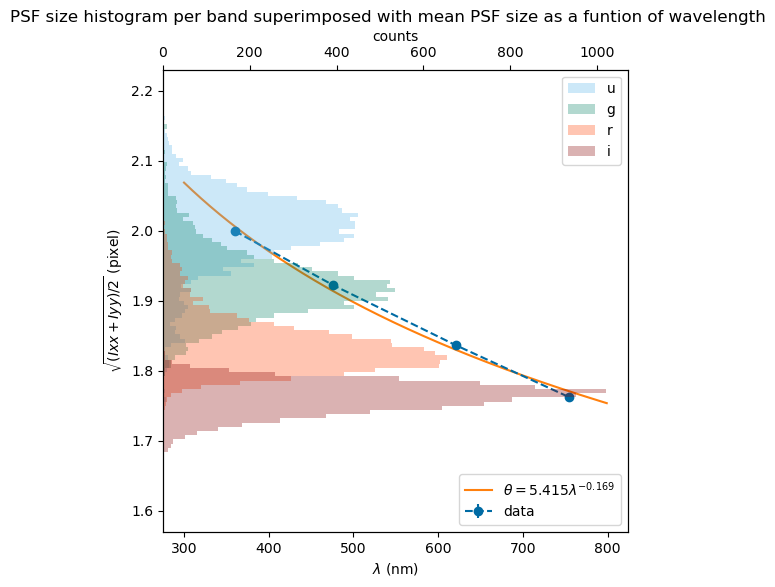

In [26]:
fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength, mean_size, std_size/np.sqrt(len(objects)),
             fmt='o--', label='data')
ax1.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()

plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}

ax2.set_xlabel('counts')
plt.hist(objects['size_u_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['u'], alpha=0.3, label='u',
         orientation="horizontal")
plt.hist(objects['size_g_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['g'], alpha=0.3, label='g',
         orientation="horizontal")
plt.hist(objects['size_r_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['r'], alpha=0.3, label='r',
         orientation="horizontal")
plt.hist(objects['size_i_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['i'], alpha=0.3, label='i',
         orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.suptitle("PSF size histogram per band superimposed with "
             "mean PSF size as a funtion of wavelength")
plt.show()

> **Figure 4**: *The figure above superimposes the size distributions per band onto the previously generated plot in Figure 3. The figure includes histograms of the size distributions corresponding to each band (`u`, `g`, `r`, and `i`), rotated 270 degrees to align their bases with the left vertical axis. The upper horizontal axis displays the histogram counts, spanning from 0 to approximately 1200 counts. Notably, this plot serves a dual role, as it incorporates both the data for the PSF size as a function of wavelength and the power-law fit from the preceding plot.*

## 5. Rho statistics with the `analysis.tools` package

Utilize [`lsst.analysis.tools`](https://github.com/lsst/analysis_tools) to compute the `rho` statistics, which are a collection of two-point correlation functions used to assess the spatial relationships between errors in PSF models. The presence of non-zero values in these statistics signifies the existence of systematic errors in the weak lensing shear correlation function. To understand their definitions, refer to [the analysis tools documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). 

`lsst.analysis.tools` is a package designed to generate quality assurance (QA) plots and metrics from the outputs of the LSST Science Pipelines. It employs `treecorr` to compute the `rho` statistics. For an introductory demonstration of `analysis_tools`, you can refer to [this Jupyter Notebook created for a session during Rubin's 2022 Project and Community Workshop](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb).

Create the `RhoStatistics` analysis structure using the `AnalysisTool`. As outlined in the [2022 Rubin PCW `analysis_tools` demo notebook](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb), the `AnalysisTool` is one of the three analysis structures provided by `analysis_tools`. It encompasses several `AnalysisAction` components, which collectively conduct specific types of analyses.

In [27]:
atool = RhoStatistics()

There are three types of `AnalysisAction`s or stages: 

- `prep` (for initial filtering of data), 
- `process` (for modyfing the data), and 
- `produce` (for generating final plots of metrics). 

Abjust a few configuration parameters from the `prep` and `process` stages.

Select stars with with signal-to-noise ratio (SNR) > 20.

In [28]:
atool.prep.selectors.snSelector.threshold = 20.0

As in a previous section, we can adjust the `treecorr` parameters before calculations, but this time it will be done via `lsst.analysis.tools`.

In [29]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

Call `atool.finalize()` after the `atool.prep` and `atool.process` stages are configured.

In [30]:
atool.finalize()

The TAP query in section 3.1 included fields that not used in that section, but that will be used in this section. 

In order to know which entries will be needed by `analysys_tools` to calculate the `rho` statistics, look at the input schema of the analysis tool `RhoStatistics`.

In [31]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_ra', 'coord_dec', '{band}_ixx', '{band}_iyy', '{band}_ixy', '{band}_ixxPSF', '{band}_iyyPSF', '{band}_ixyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


Compute the `rho` statistics in the particular band that we have chosen previously (`i`).

Start with the `prep` stage in the following cell.

In [32]:
prepResults = atool.prep(objects, band=f"{band}")

Execute the `process` stage, utilizing the outcomes obtained from the `prep` stage. Ignore the `INFO` lines.

In [33]:
processResults = atool.process(prepResults, band=f"{band}")

Access the results from `treecorr` for each `rho` statistic in order to examine the values or perform any other operation on them.

In [34]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.11941132  0.17058701  0.23287889  0.32323918  0.44497738  0.62254215
  0.86864805  1.20400898  1.67020787  2.32584702  3.23131859  4.49105588
  6.24022725  8.67353778 12.05686149 16.73875266 23.25331868 32.29273159
 44.84641098 62.25556487 86.30133468] 

Correlation function:
 [ 5.59450702e-07  1.31217885e-07  3.68707798e-07  4.22091848e-07
  5.53090179e-07  1.25834472e-07  7.43043736e-08 -1.80865648e-08
  1.30610033e-07  4.57145243e-08  5.80382439e-08  1.94315338e-08
  4.54457748e-08  6.32535229e-08  3.62393347e-08  4.05144954e-08
  4.31536599e-08  4.09903521e-08  3.94861521e-08  3.96258315e-08
  3.70525766e-08] 

Error in the correlation function:
 [2.42987317e-13 1.37692813e-13 7.24699016e-14 4.06973832e-14
 2.12927030e-14 1.19906659e-14 6.04800057e-15 3.14606580e-15
 1.67204387e-15 8.74980807e-16 4.55082559e-16 2.42416924e-16
 1.27999021e-16 6.79489146e-17 3.62381296e-17 1.96436024e-17
 1.08765389e-17 6.17699393e-18 3.59496712e-18 2.15963150e-18
 1.378

Plot the `rho` statistics using `analysis_tools` 

By default, the rho statistics are plotted on a symmetric log scale.
The threshold where the switch happens from linear to log scale can be set as follows.

In [35]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

At the moment, `atool.produce` does nto provide a direct handle to the plotting keyword arguments. 

Overwrite the global plotting parameters in order to make figures with a size suitable for a Jupyter notebook.

In [36]:
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['lines.markersize'] = 2
plt.rcParams['xtick.labelsize']=5
plt.rcParams['ytick.labelsize']=5
plt.rcParams['font.size']=5

Use `analysis_tools` to produce the `rho` statistics plots.

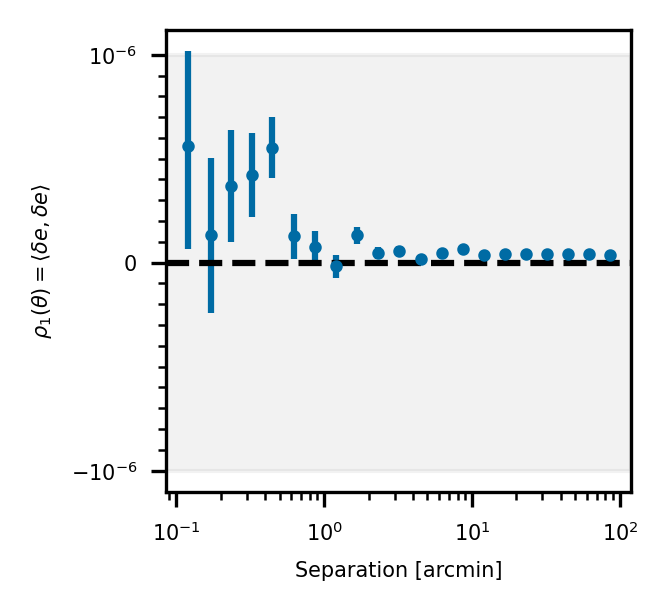

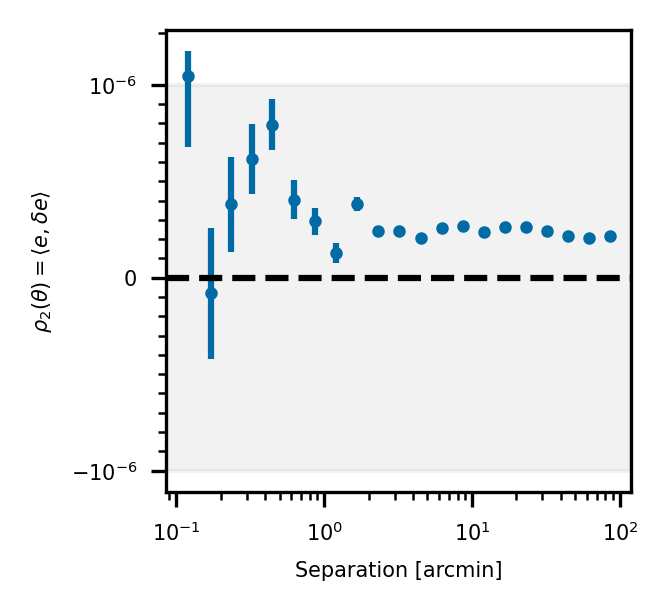

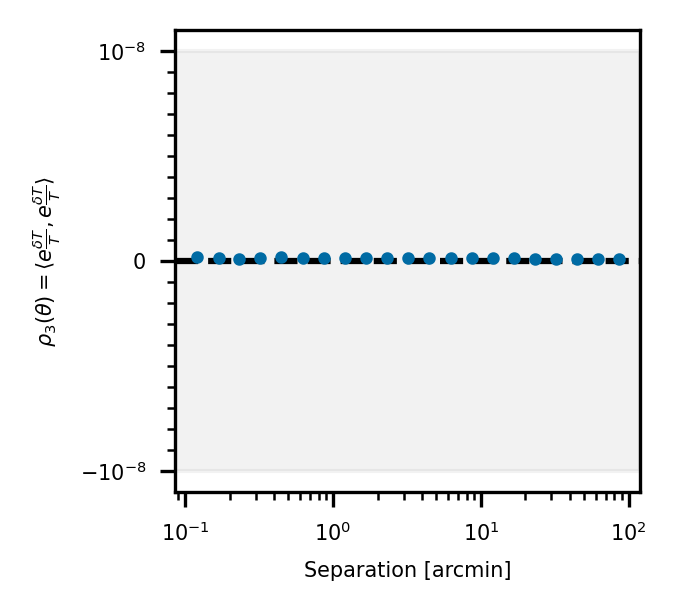

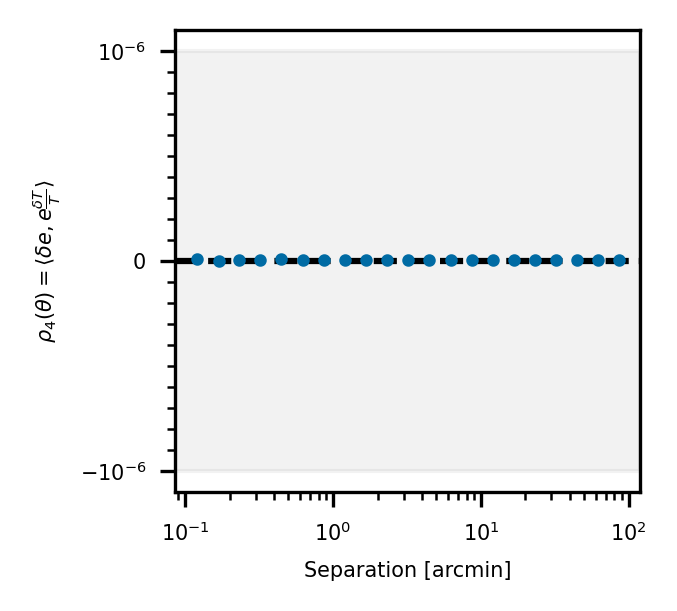

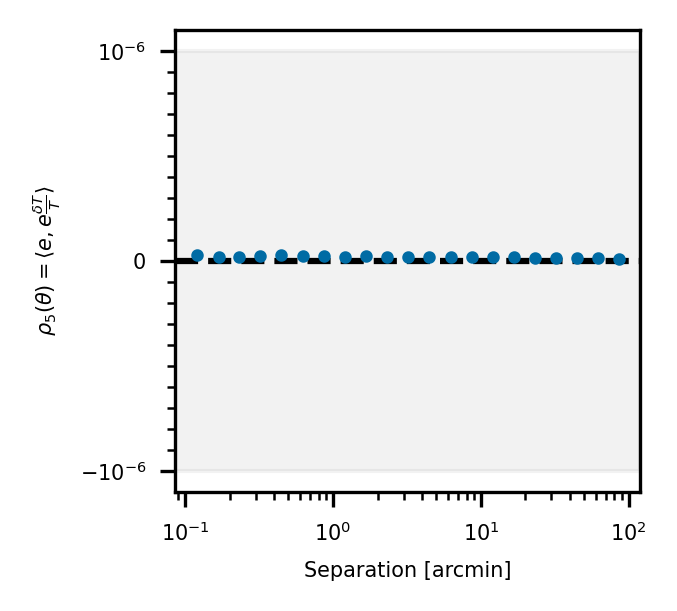

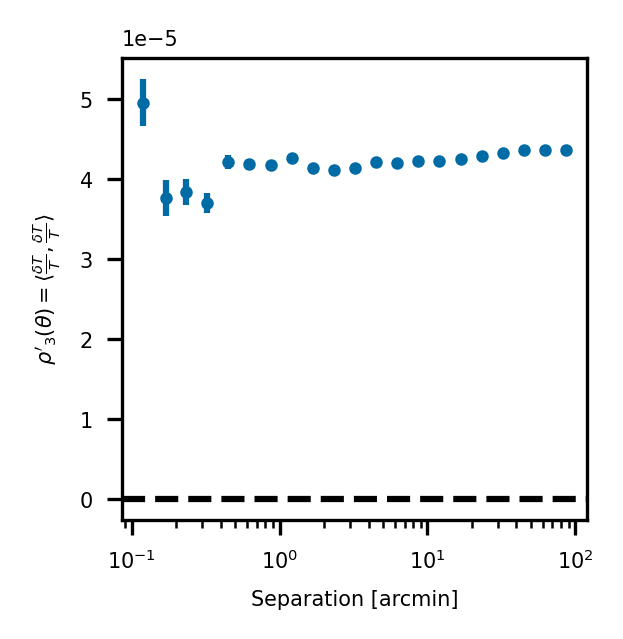

In [37]:
produceResults = atool.produce(processResults, band=f"{band}", skymap=None)

> **Figure 5** *This figure displays six plots of the `rho` statistics using `analysis_tools`. 
For other possible configuration options, you can refer to 
[the documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.plot.XYPlot.html#lsst.analysis.tools.actions.plot.XYPlot). 
The vertical axis of each plot displays the specific `rho` statistic, and the horizontal axis represents the separation in arcminutes, ranging from approximately 0.1 to 100 arcminutes on a logarithmic scale.*

As explained in [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), `rho1` (ρ1), `rho3` (ρ3), and `rho4` (ρ4) represent direct systematic errors in `xi+` (ξ+) with leading coefficients of order unity. `rho2` (ρ2) and `rho5` (ρ5) describe the extent of "PSF leakage" that occurs during the shear measurement process.

The DC2 area is relatively small and does not exhibit significant PSF variations. The `rho` statistics obtained in the previous examples (for the `i` band, considering that `rho` statistics can vary with different bands) are relatively small and well-behaved. For comparison, you can refer to Figure 26 of the [HSC Y3 shape catalog](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract) and Figure 12 of the [DES Y3 shape catalog analyses](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), which display `rho` statistics obtained from on-sky data from their respective galaxy surveys (HSC Survey and DES). These figures also include the requirements that each `rho` statistic should satisfy (e.g., Eq. 37 of [Li et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)) to ensure that there are no significant PSF modeling systematic errors that would impact the scientific goals related to cosmic shear.

## 6. Exercises for the learner

* a) Calculate the PSF ellipticity using the definition based on the second moments, as described in section 7 of [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract). Create plots similar to those in section 3 to visualize the PSF ellipticity variation across the image.

* b) Modify the query in section 2.1 to retrieve both point sources and extended sources. Create a size-magnitude diagram using the definition of size from section 2.1 (trace radius). Identify the region in the diagram where the size is constant, representing likely stars during the star-galaxy separation process. Compare your results with Figure 3 in [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract).

* a) Modify the query in section 2.1 to retrieve the required catalog fields according to the input schema for the `RhoStatistics` of `analysis_tools`. Calculate the `rho` statistics for a different band, such as the `g` band. Note that chromatic effects, including Differential Chromatic Refraction (DCR) and wavelength-dependent seeing, have a larger impact in the bluer bands. Use the `rho` statistics as a diagnostic tool to assess whether observations in these bluer bands should be included in weak lensing analyses (refer to the discussion in section 7.4 of [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).